In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 216ms/step - loss: 0.3926 - root_mean_squared_error: 0.6265 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315
Epoch 2/50
53/53 [==============================] - 10s 200ms/step - loss: 0.2459 - root_mean_squared_error: 0.4959 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3123
Epoch 3/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0857 - root_mean_squared_error: 0.2928 - val_loss: 0.1006 - val_root_mean_squared_error: 0.3172
Epoch 4/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0776 - root_mean_squared_error: 0.2785 - val_loss: 0.0904 - val_root_mean_squared_error: 0.3007
Epoch 5/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0711 - root_mean_squared_error: 0.2666 - val_loss: 0.0818 - val_root_mean_squared_error: 0.2859
Epoch 6/50
53/53 [==============================] - 10s 198ms/step - loss: 0.0651 - root_mean_squared_error: 0.2551 - val_loss: 0.0781 - 

53/53 [==============================] - 10s 198ms/step - loss: 0.0126 - root_mean_squared_error: 0.1125 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 33/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1419
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 35/50
53/53 [==============================] - 11s 203ms/step - loss: 0.0119 - root_mean_squared_error: 0.1093 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 36/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 37/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0198 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.509195319811503 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

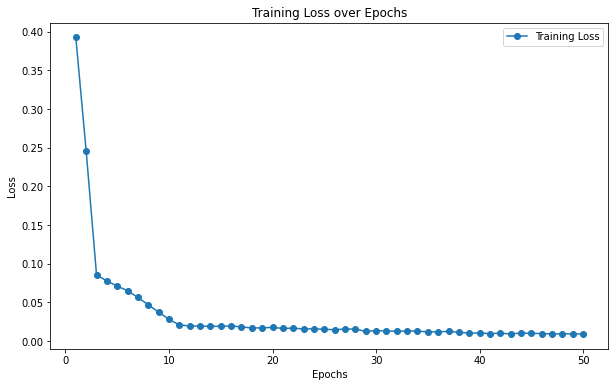

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

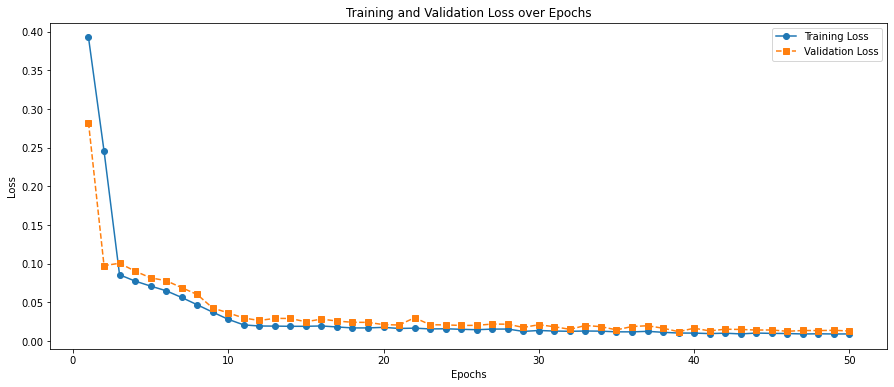

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10056865194379874
MAE : 0.08504763181515183


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.946883e+06,2086269.569
1,2.631074e+06,2852731.016
2,3.150987e+06,3452823.613
3,3.586758e+06,3846843.974
4,3.903349e+06,4005222.451
5,4.072565e+06,4129684.505
6,4.080926e+06,4130311.577
7,3.698974e+06,3987590.376
8,2.622567e+06,2531664.630
9,1.815711e+06,864796.598


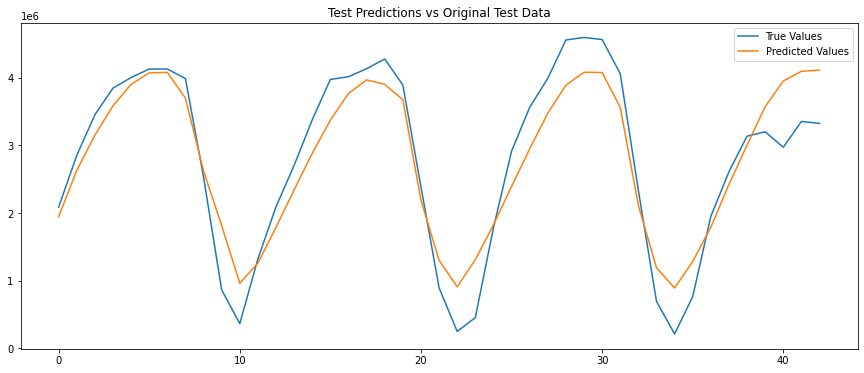

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

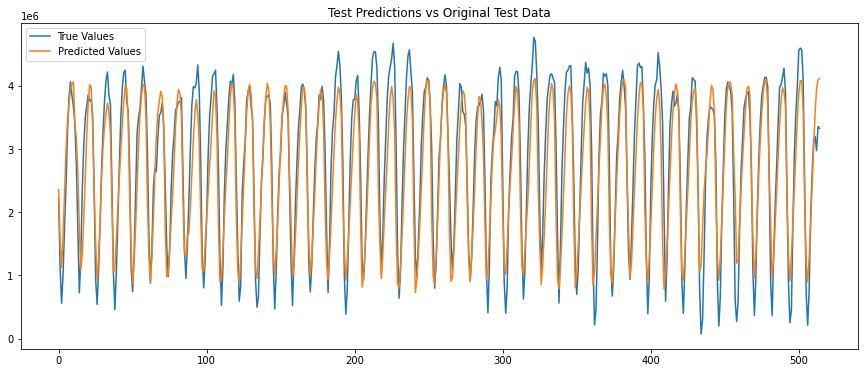

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()